# Compute lesion overlap

In [10]:
# ConWhAt stuff
from conwhat import VolConnAtlas,StreamConnAtlas,VolTractAtlas,StreamTractAtlas
from conwhat.viz.volume import plot_vol_scatter

# Neuroimaging stuff
import nibabel as nib
from nilearn.plotting import (plot_stat_map,plot_surf_roi,plot_roi,
                             plot_connectome,find_xyz_cut_coords)
from nilearn.image import resample_to_img

# Viz stuff
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# Generic stuff
import glob, numpy as np, pandas as pd, networkx as nx
from datetime import datetime

We now use the synthetic lesion constructed in the previous example in a ConWhAt lesion analysis.

In [11]:
lesion_file = 'synthetic_lesion_20mm_sphere_-46_-60_6.nii.gz' # we created this file from scratch in the previous example

Take another quick look at this mask:

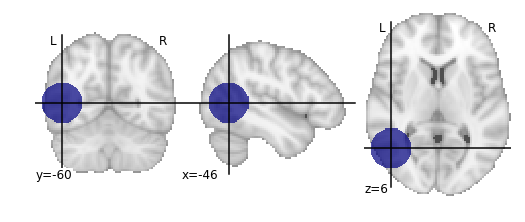

In [12]:
lesion_img = nib.load(lesion_file)
plot_roi(lesion_file);

Since our lesion mask does not (by construction) have a huge amount of spatial detail, it makes sense to use one of the lower-resolution atlas. As one might expect, computation time is considerably faster for lower-resolution atlases. 

In [5]:
cw_atlases_dir = '/global/scratch/hpc3230/Data/conwhat_atlases'  # change this accordingly
atlas_name = 'CWL2k8Sc33Vol3d100s_v01'
atlas_dir = '%s/%s' %(cw_atlases_dir, atlas_name)

See the previous tutorial on 'exploring the conwhat atlases'  for more info on how to examine the components of a given atlas in *ConWhAt*. 

Initialize the atlas

In [8]:
cw_vca = VolConnAtlas(atlas_dir=atlas_dir)

loading file mapping
loading vol bbox
loading connectivity


`cw_vca.vfms`

Choose which connections to evaluate. 

This is normally an array of numbers indexing entries in `cw_vca.vfms`.

Pre-defining connection subsets is a useful way of speeding up large analyses, especially if one is only interested in connections between specific sets of regions. 

As we are using a relatively small atlas, and our lesion is not too extensive, we can assess all connections. 

In [16]:
idxs = 'all' # alternatively, something like: range(1,100), indicates the first 100 cnxns (rows in .vmfs)

Now, compute lesion overlap statistics. 

In [18]:
jlc_dir = '/global/scratch/hpc3230/joblib_cache_dir' # this is the cache dir where joblib writes temporary files
lo_df,lo_nx = cw_vca.compute_hit_stats(lesion_file,idxs,n_jobs=4,joblib_cache_dir=jlc_dir)

computing hit stats for roi synthetic_lesion_20mm_sphere_-46_-60_6.nii.gz


This takes about 20 minutes to run. 

`vca.compute_hit_stats()` returns a `pandas` dataframe, `lo_df`, and a `networkx` object, `lo_nx`. 

Both contain mostly the same information, which is sometimes more useful in one of these formats and sometimes in the other. 

`lo_df` is a table, with rows corresponding to each connection, and columns for each of a wide set of [statistical metrics](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for evaluating sensitivity and specificity of binary hit/miss data:

In [28]:
lo_df.head()

metric,ACC,BM,F1,FDR,FN,FNR,FP,FPR,Kappa,MCC,MK,NPV,PPV,TN,TNR,TP,TPR,corr_nothr,corr_thr,corr_thrbin
idx,,,,,,,,,,,,,,,,,,,,
0,0.990646,0.104859,0.098135,0.911501,29696.0,0.889874,37851.0,0.005266,0.330534,0.094054,0.084363,0.995864,0.088499,7149810.0,0.994734,3675.0,0.110126,0.042205,0.042205,0.094054
3,0.987324,0.011683,0.014279,0.988855,32708.0,0.980132,58828.0,0.008185,0.329134,0.008766,0.006577,0.995433,0.011145,7128833.0,0.991815,663.0,0.019868,-0.001487,-0.001487,0.008766
7,0.987160,-0.006617,0.001185,0.999075,33316.0,0.998352,59404.0,0.008265,0.329023,-0.004966,-0.003727,0.995348,0.000925,7128257.0,0.991735,55.0,0.001648,-0.003549,-0.003549,-0.004966
10,0.994367,-0.000926,0.000147,0.999589,33368.0,0.999910,7305.0,0.001016,0.331450,-0.001976,-0.004215,0.995374,0.000411,7180356.0,0.998984,3.0,0.000090,-0.001975,-0.001975,-0.001976
11,0.989105,0.048907,0.044941,0.962227,31520.0,0.944533,47152.0,0.006560,0.329846,0.040403,0.033378,0.995605,0.037773,7140509.0,0.993440,1851.0,0.055467,0.017664,0.017664,0.040403


Typically we will be mainly interested in two of these metric scores:

`TPR` - True positive (i.e. hit) rate: number of true positives, divided by number of true positives + number of false negatives


`corr_thrbin` -  Pearson correlation between the lesion amge and the thresholded, binarized connectome edge image (group-level visitation map)

In [27]:
lo_df[['TPR', 'corr_thrbin']].iloc[:10].T

idx,0,3,7,10,11,13,14,15,18,19
metric,,,,,,,,,,
TPR,0.110126,0.019868,0.001648,0.000090,0.055467,0.002128,0.000569,0.000000,0.098469,0.023523
corr_thrbin,0.094054,0.008766,-0.004966,-0.001976,0.040403,0.005801,0.000641,-0.002543,0.169234,0.029414


We can obtain these numbers as a 'modification matrix' (connectivity matrix)

In [33]:
tpr_adj = nx.to_pandas_adjacency(lo_nx,weight='TPR')
cpr_adj = nx.to_pandas_adjacency(lo_nx,weight='corr_thrbin')

These two maps are, unsurprisingly, very similar:

In [104]:
np.corrcoef(tpr_adj.values.ravel(), cpr_adj.values.ravel())

array([[1.        , 0.96271946],
       [0.96271946, 1.        ]])

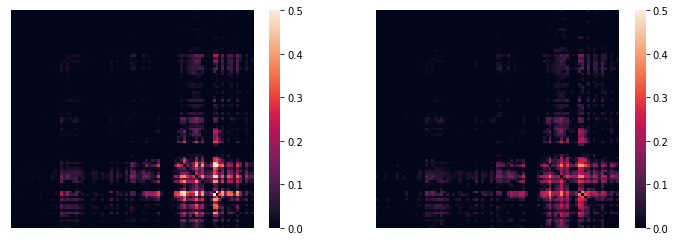

In [79]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))

sns.heatmap(tpr_adj,xticklabels='',yticklabels='',vmin=0,vmax=0.5,ax=ax[0]);

sns.heatmap(cpr_adj,xticklabels='',yticklabels='',vmin=0,vmax=0.5,ax=ax[1]);

(...with an alternative color scheme...)

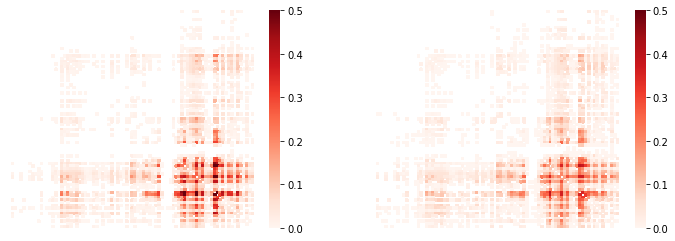

In [70]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))

sns.heatmap(tpr_adj, xticklabels='',yticklabels='',cmap='Reds',
                   mask=tpr_adj.values==0,vmin=0,vmax=0.5,ax=ax[0]);

sns.heatmap(cpr_adj,xticklabels='',yticklabels='',cmap='Reds',
                   mask=cpr_adj.values==0,vmin=0,vmax=0.5,ax=ax[1]);

We can list directly the most affected (greatest % overlap) connections, 

In [85]:
cw_vca.vfms.loc[lo_df.index].head()

,name,nii_file,nii_file_id,4dvolind
idx,,,,
0,61_to_80,vismap_grp_62-81_norm.nii.gz,0,NaN
3,18_to_19,vismap_grp_19-20_norm.nii.gz,3,NaN
7,45_to_48,vismap_grp_46-49_norm.nii.gz,7,NaN
10,19_to_68,vismap_grp_20-69_norm.nii.gz,10,NaN
11,21_to_61,vismap_grp_22-62_norm.nii.gz,11,NaN


To plot the modification matrix information on a brain, we first need to some spatial locations to plot as nodes. For these, we calculate (an approprixation to) each atlas region's centriod location:

In [101]:
parc_img = cw_vca.region_nii
parc_dat = parc_img.get_data()
parc_vals = np.unique(parc_dat)[1:]

ccs = {roival: find_xyz_cut_coords(nib.Nifti1Image((dat==roival).astype(int),img.affine),
                                   activation_threshold=0) for roival in roivals}
ccs_arr = np.array(ccs.values())

Now plotting on a glass brain:

In [1]:
fig, ax = plt.subplots(figsize=(16,6))
plot_connectome(tpr_adj.values,ccs_arr,axes=ax,edge_threshold=0.2,colorbar=True,
                    edge_cmap='Reds',edge_vmin=0,edge_vmax=1.,
                    node_color='lightgrey',node_kwargs={'alpha': 0.4});
#edge_vmin=0,edge_vmax=1)

NameError: name 'plt' is not defined

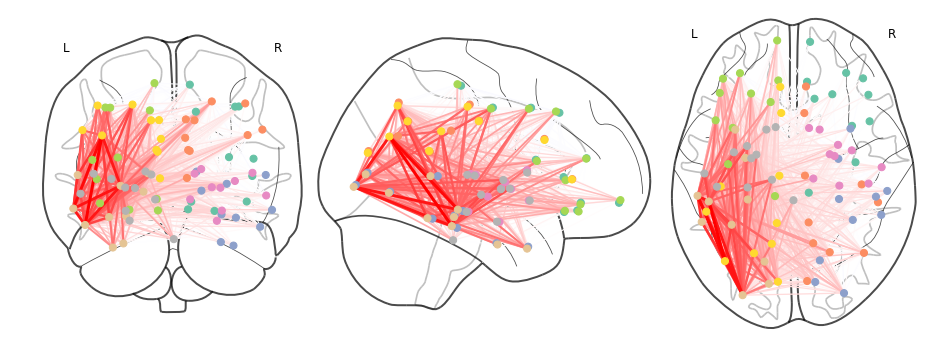

In [118]:
fig, ax = plt.subplots(figsize=(16,6))
plot_connectome(cpr_adj.values,ccs_arr,axes=ax)